# Steady State - Households

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Mortality and population](#toc2_)    
- 3. [Labor supply](#toc3_)    
- 4. [Consumption-saving](#toc4_)    
  - 4.1. [Comparison with data](#toc4_1_)    
- 5. [Varying central inputs](#toc5_)    
- 6. [Test household block](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [287]:
%load_ext autoreload
%autoreload 2
import copy
import pickle
import numpy as np
import ipywidgets as widgets

import matplotlib.pyplot as plt   
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [288]:
from steady_state import household_search_ss, find_household_consumption_ss, find_Aq_ss, find_ss     # import household steady state functions 


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [289]:
model = BabyMAKROModelClass(name='baseline')    # create an instance of the model

In [290]:
par = model.par     # unpack model parameters
ss = model.ss       # unpack namespace for steady state
sol = model.sol     # unpack namespace for solution


## 2. <a id='toc2_'></a>[Mortality and population](#toc0_)

In [291]:
def mortality_and_population_figure(model,zeta):

    # a. set mortality rate and population
    model.par.zeta = zeta
    model.mortality()
    model.demographic_structure()

    # b. construct figure
    fig = plt.figure(figsize=(3*6,6/1.5))

    ax = fig.add_subplot(1,3,1)
    ages = par.age_ini+np.arange(par.life_span)
    ax.plot(ages,par.zeta_a*100)
    ax.set_ylabel('%')
    ax.set_title('Mortality rate, $\zeta_a$')

    ax = fig.add_subplot(1,3,2)
    ages = par.age_ini+np.arange(par.life_span+1)
    ax.plot(ages,np.append(par.N_a,0.0))
    retirement_age = ax.vlines(par.age_ini+par.work_life_span,0,1.05,colors='orange',linestyles='dashed', label='retirement age')
    ax.legend(handles = [retirement_age],frameon=True)
    ax.set_title('Population, $N_a$')

    print(f'Population size: {par.N = :.1f}')
    print(f'Population size of the workforce: {par.N_work = :.1f}')
    

In [292]:
widgets.interact(lambda zeta: mortality_and_population_figure(model.copy(),zeta),
    zeta=widgets.FloatText(description="zeta", value=par.zeta));

interactive(children=(FloatText(value=4.0, description='zeta'), Output()), _dom_classes=('widget-interact',))

## 3. <a id='toc3_'></a>[Labor supply](#toc0_)

**Required inputs:**

In [293]:
ss.m_s = par.m_v_ss                    # set steady state for the job-finding rate

**Solve:**

In [294]:
household_search_ss(par,ss)            # find the household search behavior in steady state

In [295]:
def household_search_figure(model,delta_L_a_fac):
    
    par = model.par
    ss = model.ss

    # a. set job 
    par.delta_L_a_fac = delta_L_a_fac
    model.job_separation_rate()

    # b. calculate search in steady state
    household_search_ss(par,ss)   
    
    # c. construct figure
    fig = plt.figure(figsize=(3*7,6/1.5))

    ages = par.age_ini + np.arange(par.life_span)
    ages_work = par.age_ini + np.arange(par.work_life_span)

    ax = fig.add_subplot(1,4,1)
    ax.plot(ages_work,par.delta_L_a*100)
    ax.set_ylabel('%')
    ax.set_ylim([0, 105])
    ax.set_title('Separation rate, $\delta^L_a$');

    ax = fig.add_subplot(1,4,2)
    ax.plot(ages,ss.S_a)
    ax.set_ylim([0, 1.05])
    ax.set_title('Searchers, $S_a$')

    ax = fig.add_subplot(1,4,3)
    ax.plot(ages,ss.L_a)
    ax.set_ylim([0, 1.1])
    employed = ax.fill_between(range(par.age_ini,par.age_ini+par.work_life_span),ss.L_a[0:par.work_life_span],color="b",alpha=0.15, label='$L_a$')
    unemployed = ax.fill_between(range(par.age_ini,par.age_ini+par.work_life_span),ss.L_a[0:par.work_life_span],1,color="r",alpha=0.15, label='$U_a$')
    m_s = ax.hlines(ss.m_s,par.age_ini,par.age_ini+par.work_life_span,colors='orange',linestyles='dashed', label='$m^s$')
    ax.legend(handles=[employed,unemployed,m_s],loc=1,frameon=True)
    ax.set_title('Employed, $L_a$, and unemployed, $U_a$');

    ax = fig.add_subplot(1,4,4)
    ax.plot(ages,ss.U_a)
    ax.set_ylim([0, 1.0])
    ax.set_title('$U_a$')


In [296]:
widgets.interact(lambda delta_L_a_fac: household_search_figure(model.copy(),delta_L_a_fac),
    delta_L_a_fac=widgets.FloatSlider(description="delta_L_a_fac", min=0.0, max=1, value=par.delta_L_a_fac));

interactive(children=(FloatSlider(value=0.1, description='delta_L_a_fac', max=1.0), Output()), _dom_classes=('…

## 4. <a id='toc4_'></a>[Consumption-saving](#toc0_)

**Required inputs:**

In [297]:
ss.W = par.W_ss                                 # set steady state wage
ss.pi_hh = par.pi_hh_ss                         # set steady state inflation
ss.P_C = 1.0                                    # set steady state consumer price
ss.tau = 0.40                                   # set steady state tax rate
ss.Aq = Aq_ini = 0.0                            # set steady state bequests
ss.r_hh = par.r_hh                              # set steady state interest rate
ss.real_r_hh = (1+ss.r_hh)/(1+ss.pi_hh)-1       # set steady state real interest rate

**Solve:**

In [298]:
find_household_consumption_ss(model) # find household bequests behavior
find_Aq_ss(ss.Aq,model)            # find household bequests behavior

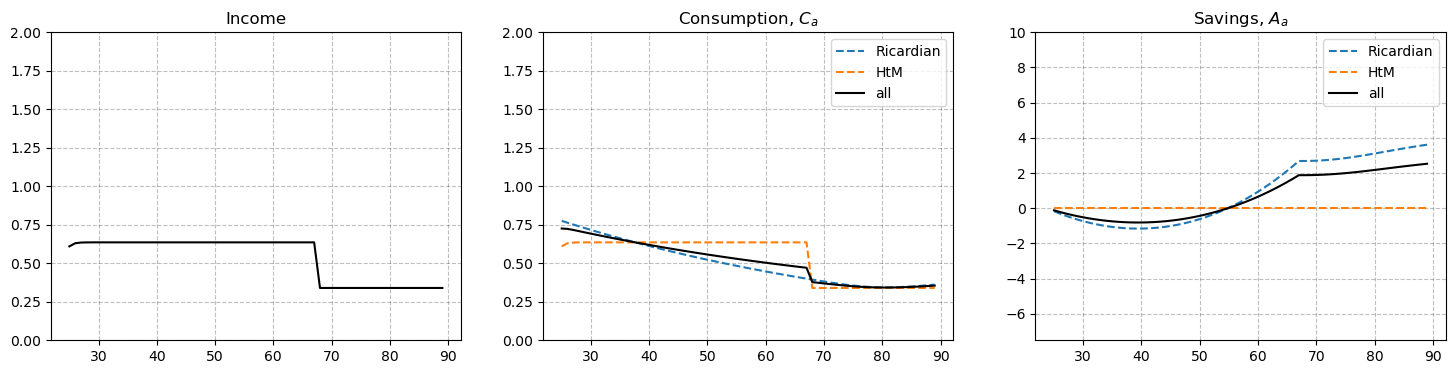

In [299]:

def plot_CA():
    
    fig = plt.figure(figsize=(3*6,1*6/1.5))

    ages = par.age_ini + np.arange(par.life_span)

    ax = fig.add_subplot(1,3,1)
    ax.plot(ages,ss.inc_a,label='all',color='black')
    ax.set_title('Income');
    ax.set_ylim([0,2.0])
    
    ax = fig.add_subplot(1,3,2)
    ax.plot(ages,ss.C_R_a,ls='--',label='Ricardian')
    ax.plot(ages,ss.C_HtM_a,ls='--',label='HtM')
    ax.plot(ages,ss.C_a,label='all',color='black')
    ax.set_title('Consumption, $C_a$');
    ax.set_ylim([0,2.0])
    ax.legend(frameon=True)
    
    ax = fig.add_subplot(1,3,3)
    ax.plot(ages,ss.A_R_a,ls='--',label='Ricardian')
    ax.plot(ages,ss.A_HtM_a,ls='--',label='HtM')
    ax.plot(ages,ss.A_a,label='all',color='black')
    ax.set_title('Savings, $A_a$')
    ax.set_ylim([-7.5,10])
    ax.legend(frameon=True)
    
plot_CA()   



### 4.1. <a id='toc4_1_'></a>[Comparison with data](#toc0_)

In [300]:
# load data
with open('data/ss_households_income.pickle', 'rb') as f:
    ss_households_income = pickle.load(f)

with open('data/ss_households_wealth.pickle', 'rb') as f:
    ss_households_wealth = pickle.load(f)    

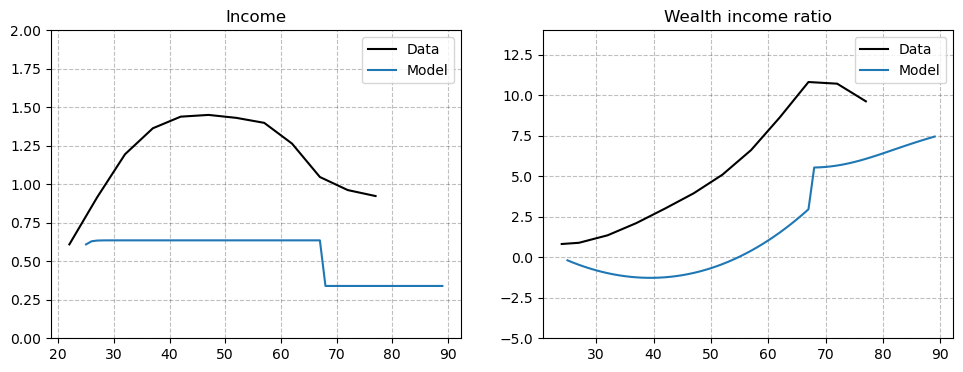

In [301]:
fig = plt.figure(figsize=(3*6,1*6/1.5))

ages = par.age_ini + np.arange(par.life_span)

ax = fig.add_subplot(1,3,1)
fac = ss.inc_a[0]/ss_households_income['income'][0]
ax.plot(ss_households_income['age'],ss_households_income['income']*fac,label='Data',color='black')
ax.plot(ages,ss.inc_a,label='Model')
ax.set_title('Income');
ax.set_ylim([0,2]);
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(ss_households_wealth['age'],ss_households_wealth['wealth_income_ratio'],label='Data',color='black')
ax.plot(ages,ss.A_a/ss.inc_a,label='Model')
ax.set_title('Wealth income ratio');
ax.set_ylim([-5,14]);
ax.legend()

## 5. <a id='toc5_'></a>[Varying central inputs](#toc0_)

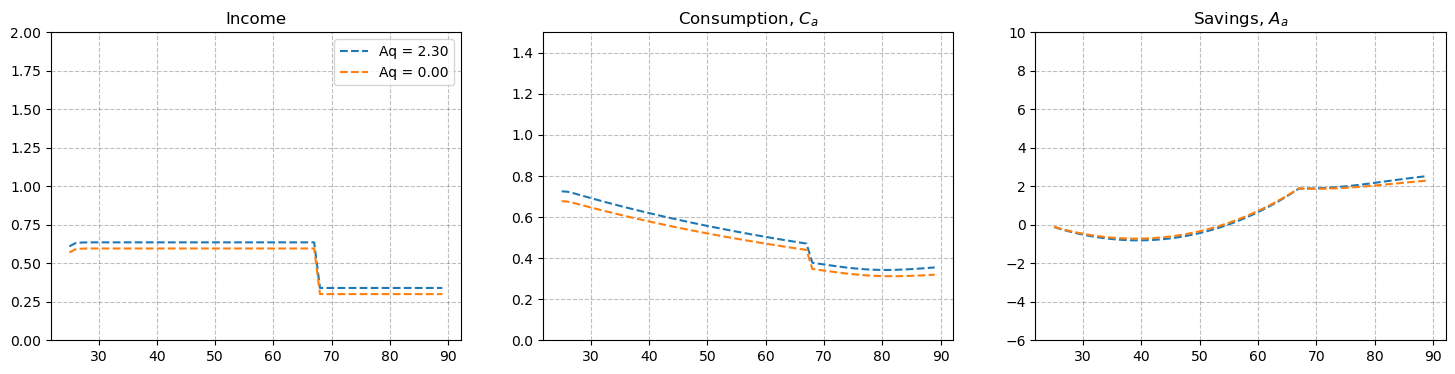

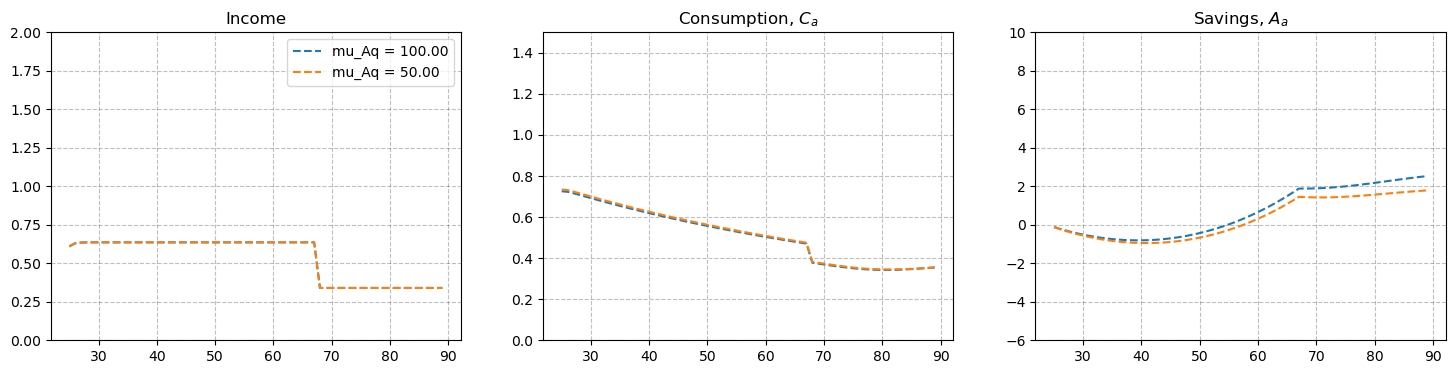

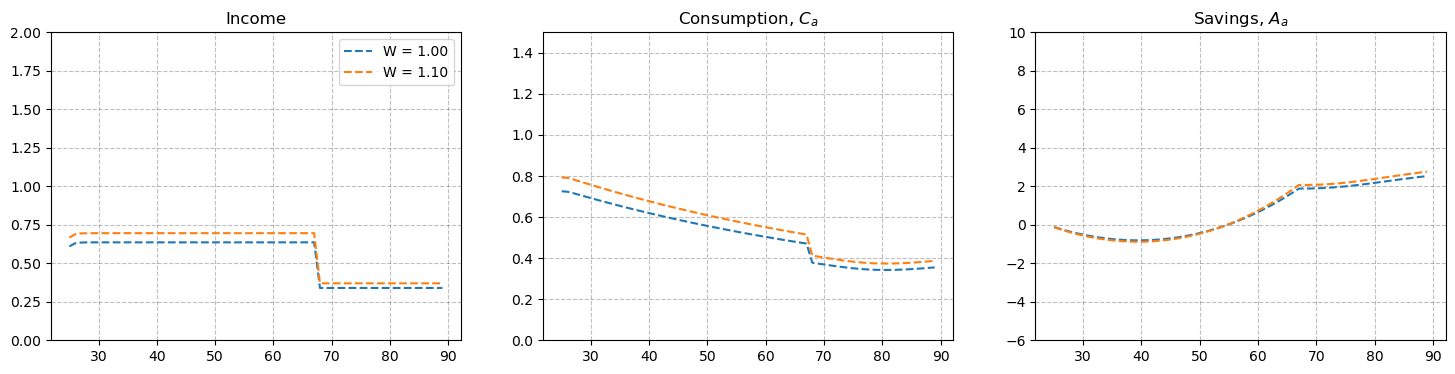

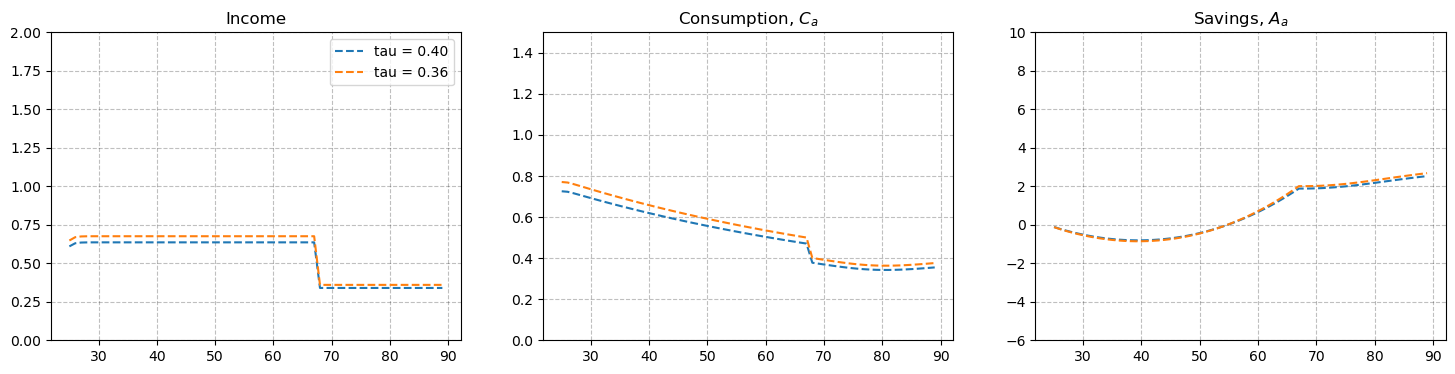

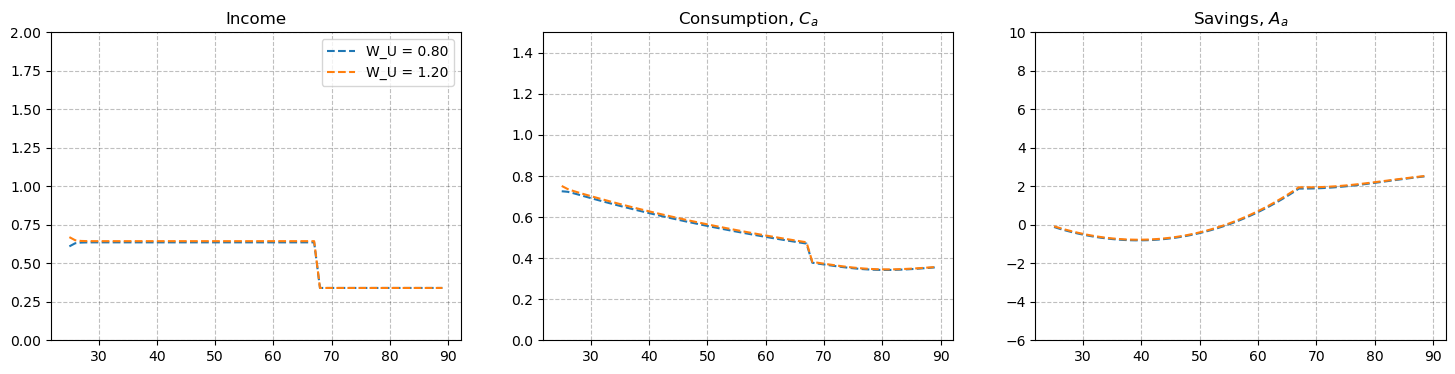

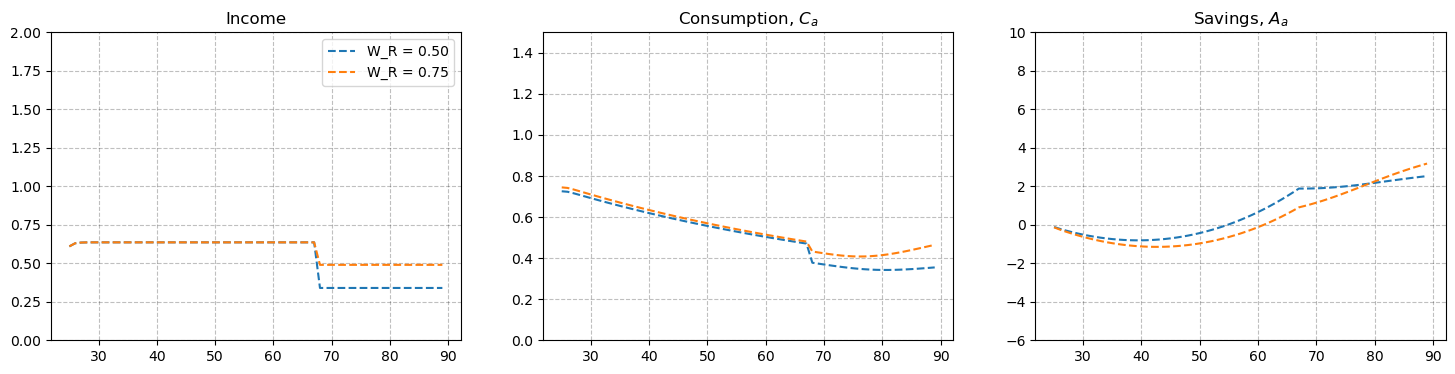

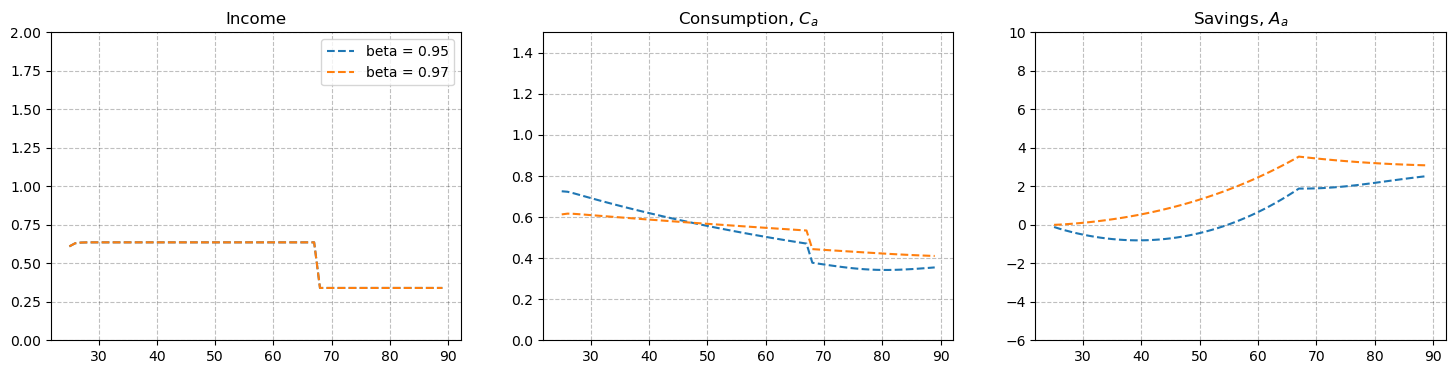

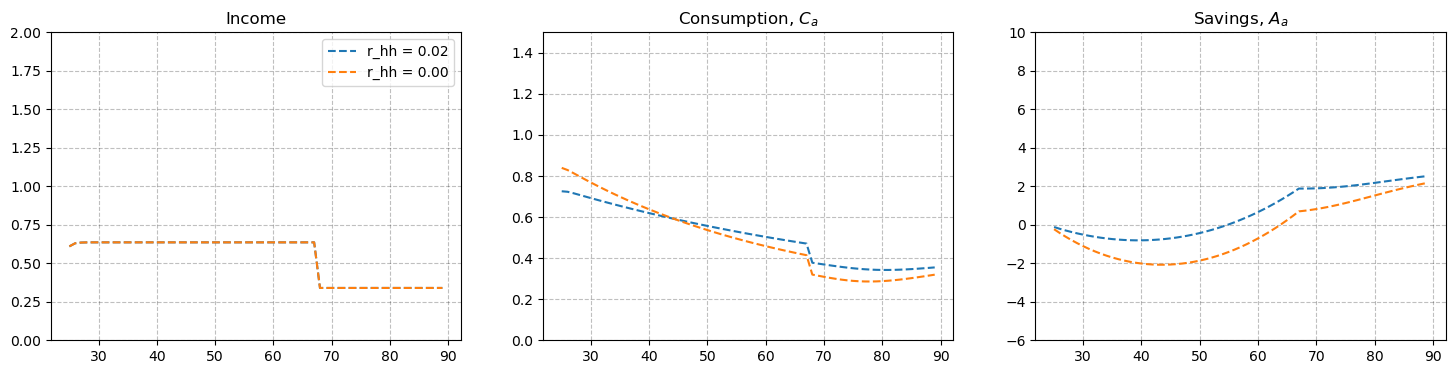

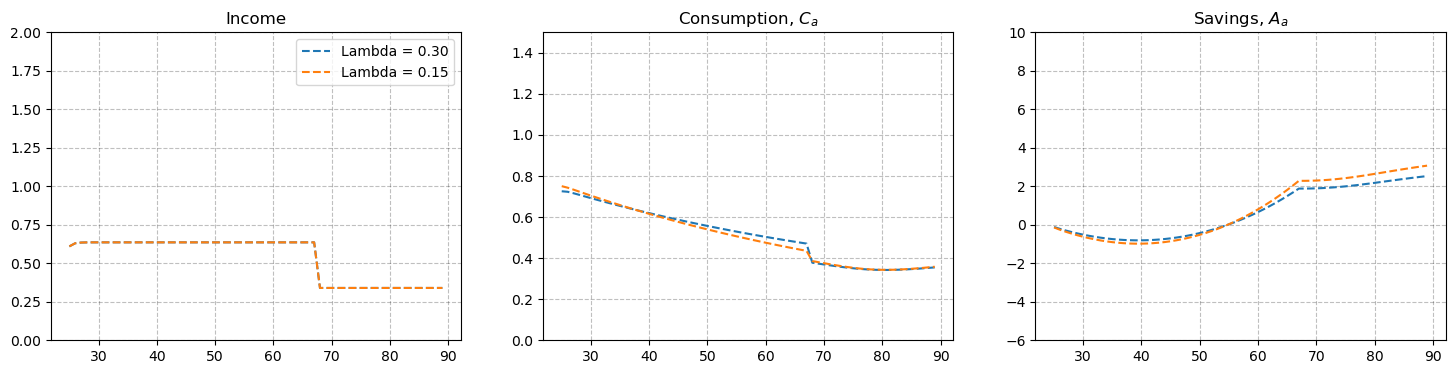

In [302]:
def compare_models(model,name,value,ns='ss'):

    model_ = model.copy()
    
    if ns == 'ss':
        model_.ss.__dict__[name] = value
        oldvalue = model.ss.__dict__[name]
    elif ns == 'par':
        model_.par.__dict__[name] = value
        oldvalue = model.par.__dict__[name]
    else:
        raise NotImplemented
            
    model_.ss.real_r_hh = (1+model_.par.r_hh)/(1+model_.ss.pi_hh)-1            
    find_household_consumption_ss(model_)

    fig = plt.figure(figsize=(3*6,1*6/1.5))

    ages = par.age_ini + np.arange(par.life_span)

    ax = fig.add_subplot(1,3,1)
    ax.plot(ages,ss.inc_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(ages,model_.ss.inc_a,ls='--',label=f'{name} = {value:.2f}')
    ax.set_title('Income');
    ax.set_ylim([0,2.0])
    ax.legend(frameon=True)
    
    ax = fig.add_subplot(1,3,2)
    ax.plot(ages,ss.C_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(ages,model_.ss.C_a,ls='--',label=f'{name} = {value:.2f}')
    ax.set_title('Consumption, $C_a$');
    ax.set_ylim([0,1.5])
    
    ax = fig.add_subplot(1,3,3)
    ax.plot(ages,ss.A_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(ages,model_.ss.A_a,ls='--',label=f'{name} = {value:.2f}')
    ax.set_title('Savings, $A_a$')
    ax.set_ylim([-6,10])
    
compare_models(model,'Aq',ss.Aq*0.0)
compare_models(model,'mu_Aq',par.mu_Aq/2,ns='par')
compare_models(model,'W',ss.W*1.1)
compare_models(model,'tau',ss.tau*0.9)
compare_models(model,'W_U',par.W_U*1.5,ns='par')
compare_models(model,'W_R',par.W_R*1.5,ns='par')
compare_models(model,'beta',par.beta+0.02,ns='par')
compare_models(model,'r_hh',par.r_hh-0.02,ns='par')
compare_models(model,'Lambda',par.Lambda/2,ns='par')


## 6. <a id='toc6_'></a>[Test household block](#toc0_)

In [303]:
sol.A_R_death[:] = ss.A_R_a[-1]                     # set solution for last period assets
sol.Aq[:] = ss.Aq                                   # set solution for bequests
sol.P_C[:] = ss.P_C                                 # set solution for consumer price
sol.W[:] = ss.W                                     # set solution for wage
sol.tau[:] = ss.tau                                 # set solution for tax rate
sol.L[:] = ss.L                                     # set solution for labor supply
sol.m_s[:] = ss.m_s                                 # set solution for job-finding rate
sol.r_hh[:] = ss.r_hh                               # set solution for interest rate
sol.real_r_hh[:] = ss.real_r_hh                     # set solution for real interest rate

In [304]:
model.ini = ss                                      # set model initial to steady state

In [305]:
model.evaluate_block('search_and_match')            # evaluate the search and matching behavior

In [306]:
assert np.allclose(sol.S_a-ss.S_a[:,np.newaxis,np.newaxis],0.0)
assert np.allclose(sol.L_ubar_a-ss.L_ubar_a[:,np.newaxis,np.newaxis],0.0)
assert np.allclose(sol.L_a-ss.L_a[:,np.newaxis,np.newaxis],0.0)
assert np.allclose(sol.U_a-ss.U_a[:,np.newaxis,np.newaxis],0.0)
assert np.allclose(sol.S-ss.S,0.0)
assert np.allclose(sol.L_ubar-ss.L_ubar,0.0)
assert np.allclose(sol.U-ss.U,0.0)

In [307]:
model.evaluate_block('household_income')            # evaluate the household income
model.evaluate_block('household_consumption_HtM')   # evaluate consumption of the HtM households
model.evaluate_block('household_consumption_R')     # evaluate consumption of the R households
model.evaluate_block('household_A_R_ini_error')     # evaluate initial bequests of the households
model.evaluate_block('household_aggregate')         # evaluate wealth of the households

In [308]:
assert np.allclose(sol.Aq_diff,0.0)
assert np.allclose(sol.A_R_ini_error,0.0)